In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

In [46]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [47]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [48]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [5]:
# Creating new family_size column
df['Family_Size']=df['SibSp']+df['Parch']

In [6]:
cat_cols = ['Pclass','Sex','Embarked']
cont_cols = ['Age','Family_Size','Fare']
y_col = ['Survived']  # this column contains the labels

In [7]:
# Convert the three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [8]:
df.dtypes

PassengerId       int64
Survived          int64
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
Family_Size       int64
dtype: object

In [9]:
# Pclass = 1:0 , 2:1 , 3:2
# Sex = female:0 , male:1 
# Embarked = C:0 , Q:1 , S:2

In [10]:
pc = df['Pclass'].cat.codes.values
sex = df['Sex'].cat.codes.values
ebrk = df['Embarked'].cat.codes.values

cats = np.stack([pc, sex, ebrk], 1)

cats[:5]

array([[2, 1, 2],
       [0, 0, 0],
       [2, 0, 2],
       [0, 0, 2],
       [2, 1, 2]], dtype=int8)

In [11]:
# Taking care of missing data
from sklearn.impute import SimpleImputer
missingvalues = SimpleImputer(missing_values = -1 , strategy = 'median', verbose = 0)  
missingvalues = missingvalues.fit(cats[:,1:3])
cats[:,1:3] = missingvalues.transform(cats[:,1:3])

In [12]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)

cats[:5]

tensor([[2, 1, 2],
        [0, 0, 0],
        [2, 0, 2],
        [0, 0, 2],
        [2, 1, 2]])

In [13]:
conts = np.stack([df[col].values for col in cont_cols], 1)

In [14]:
# Taking care of missing data
from sklearn.impute import SimpleImputer
missingvalues = SimpleImputer(missing_values = np.nan, strategy = 'mean', verbose = 0)  
missingvalues = missingvalues.fit(conts[:,0:1])
conts[:,0:1] = missingvalues.transform(conts[:,0:1])

In [15]:
# Convert continuous variables to a tensor
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[22.0000,  1.0000,  7.2500],
        [38.0000,  1.0000, 71.2833],
        [26.0000,  0.0000,  7.9250],
        [35.0000,  1.0000, 53.1000],
        [35.0000,  0.0000,  8.0500]])

In [16]:
conts.type()

'torch.FloatTensor'

In [17]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values).flatten()

y[:5]

tensor([0, 1, 1, 1, 0])

In [18]:
cats.shape

torch.Size([891, 3])

In [19]:
conts.shape

torch.Size([891, 3])

In [20]:
y.shape

torch.Size([891])

In [21]:
# This will set embedding sizes for Pclass, Sex and Embarked
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(3, 2), (2, 1), (3, 2)]

In [22]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [23]:
torch.manual_seed(101)
model = TabularModel(emb_szs, conts.shape[1], 2, [100,50], p=0.4) # out_sz = 2

In [24]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(2, 1)
    (2): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
batch_size = 891
test_size = 191

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [27]:
len(con_train)

700

In [28]:
len(cat_test)

191

In [29]:
import time
start_time = time.time()

epochs = 200
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.84363061
epoch:  26  loss: 0.65861762
epoch:  51  loss: 0.60503906
epoch:  76  loss: 0.59684759
epoch: 101  loss: 0.57633549
epoch: 126  loss: 0.56821519
epoch: 151  loss: 0.55181152
epoch: 176  loss: 0.57446468
epoch: 200  loss: 0.53789479

Duration: 5 seconds


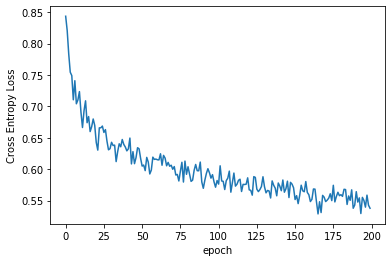

In [30]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [31]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.51417935


In [32]:
rows = 191
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([-0.4685,  0.3464])    1      1   
tensor([-0.5895,  0.0848])    1      1   
tensor([0.5475, 0.8200])      1      0   
tensor([ 0.1495, -1.1847])    0      0   
tensor([0.2886, 0.2120])      0      0   
tensor([-0.6837, -0.0866])    1      0   
tensor([-0.3021, -1.2670])    0      1   
tensor([0.2529, 0.1128])      0      1   
tensor([-0.7946,  0.3969])    1      1   
tensor([ 0.8101, -0.7818])    0      1   
tensor([0.1319, 0.1903])      1      1   
tensor([-0.2503,  0.2405])    1      0   
tensor([-0.2012, -0.6219])    0      1   
tensor([ 0.7803, -0.6024])    0      0   
tensor([ 1.3680, -0.5207])    0      0   
tensor([0.3418, 0.1618])      0      0   
tensor([0.1178, 1.9511])      1      1   
tensor([-0.4506, -1.2895])    0      1   
tensor([0.3965, 0.7420])      1      0   
tensor([ 0.4298, -0.7398])    0      0   
tensor([-0.9765, -0.2184])    1      1   
tensor([ 0.9589, -0.6388])    0      0   
tensor([ 1.0082, -0.6269])    0   

In [33]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TitanicModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

In [34]:
# INPUT NEW DATA
df2 = pd.read_csv('test.csv')
    
# PREPROCESS THE DATA
df2['Family_Size']= df2['SibSp'] + df2['Parch']

# CREATE CAT AND CONT TENSORS
cat_cols = ['Pclass','Sex','Embarked']
cont_cols = ['Age','Family_Size','Fare']

# Convert the three categorical columns to category dtypes.
for cat in cat_cols:
    df2[cat] = df2[cat].astype('category')
    
pc = df2['Pclass'].cat.codes.values
sex = df2['Sex'].cat.codes.values
ebrk = df2['Embarked'].cat.codes.values

cats2 = np.stack([pc, sex, ebrk], 1)
cats2 = torch.tensor(cats2, dtype=torch.int64)
    
conts2 = np.stack([df2[col].values for col in cont_cols], 1)
from sklearn.impute import SimpleImputer
missingvalues = SimpleImputer(missing_values = np.nan, strategy = 'mean', verbose = 0)  
missingvalues = missingvalues.fit(conts2[:,0:3])
conts2[:,0:3] = missingvalues.transform(conts2[:,0:3])
conts2 = torch.tensor(conts2, dtype=torch.float)

In [35]:
model2 = TabularModel(emb_szs, conts2.shape[1], 2, [100,50], p=0.4)
model2.load_state_dict(torch.load('TitanicModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(2, 1)
    (2): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [36]:
# TO EVALUATE THE ENTIRE TEST2 SET
with torch.no_grad():
    y_val2 = model2(cats2, conts2)

rows = 418
print(f'{"MODEL OUTPUT":26} ARGMAX')
for i in range(rows):
    print(f'{str(y_val2[i]):26} {y_val2[i].argmax():^7}')


MODEL OUTPUT               ARGMAX
tensor([ 0.2999, -0.8735])    0   
tensor([ 0.4501, -0.5728])    0   
tensor([ 1.1922, -1.0289])    0   
tensor([ 0.4000, -0.7844])    0   
tensor([-0.0418, -0.0163])    1   
tensor([ 0.1286, -0.3787])    0   
tensor([-0.5117, -0.3642])    1   
tensor([ 0.3137, -0.0470])    0   
tensor([ 0.2685, -0.0883])    0   
tensor([ 0.1181, -0.1573])    0   
tensor([ 0.4623, -0.8710])    0   
tensor([-0.0218, -0.7702])    0   
tensor([-0.6404,  0.8244])    1   
tensor([ 0.7754, -0.4730])    0   
tensor([-0.6790,  0.1883])    1   
tensor([-0.0461,  0.2528])    1   
tensor([ 0.2569, -0.7802])    0   
tensor([ 0.5198, -0.5888])    0   
tensor([ 0.0972, -0.3613])    0   
tensor([ 0.4764, -0.7371])    0   
tensor([-0.4004, -0.3656])    1   
tensor([-0.0161, -0.1567])    0   
tensor([-0.4884,  0.2868])    1   
tensor([-0.2494,  0.6429])    1   
tensor([-0.3296,  0.7342])    1   
tensor([ 0.7907, -0.7611])    0   
tensor([-0.4206,  0.8825])    1   
tensor([ 0.5534, -0.6

tensor([ 0.1405, -0.7605])    0   
tensor([-0.4485,  0.1325])    1   
tensor([ 0.2672, -0.6374])    0   
tensor([-0.5192, -0.3080])    1   
tensor([ 0.4982, -0.5534])    0   
tensor([-0.1865,  0.3586])    1   
tensor([-0.8761,  0.3595])    1   
tensor([-0.2566, -0.5294])    0   
tensor([-0.0191,  0.0960])    1   
tensor([-0.5239,  0.3240])    1   
tensor([ 0.4625, -0.8711])    0   
tensor([ 0.6072, -0.4002])    0   
tensor([-0.2367, -0.0834])    1   
tensor([-0.2454, -0.0459])    1   
tensor([ 0.5049, -0.2237])    0   
tensor([-0.4087,  0.1532])    1   
tensor([ 0.2007, -0.2663])    0   
tensor([-0.4247,  0.6991])    1   
tensor([ 0.2653, -0.6362])    0   
tensor([-0.3052,  0.7919])    1   
tensor([ 0.3215, -0.6960])    0   
tensor([ 0.4222, -0.9008])    0   
tensor([ 0.4723, -0.8765])    0   
tensor([ 0.1419, -0.7615])    0   
tensor([ 0.4351, -0.8219])    0   
tensor([ 0.0563, -0.1007])    0   
tensor([ 0.2929, -0.6587])    0   
tensor([ 0.4607, -0.7294])    0   
tensor([ 0.2907, -0.